<h1>Исследование причин убытков приложения Procrastinate Pro+</h1>
<p>В нашем распоряжении имеются данные о пользователях привлечённых с 1 мая по 27 октября 2019 года:
<ul>
    <li>лог сервера с данными об их посещениях,
    <li>выгрузка их покупок за этот период,
    <li>рекламные расходы.
</ul>

<p>Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.
    
<p><b>Цель исследования:</b>
<ul>    
    <li>Изучить откуда приходят пользователи и какими устройствами они пользуются,
    <li>Cколько стоит привлечение пользователей из различных рекламных каналов;
    <li>сколько денег приносит каждый клиент,
    <li>когда расходы на привлечение клиента окупаются,
    <li>какие факторы мешают привлечению клиентов.
</ul>
<p><b>Ход исследования</b></p>
<ol>
    <li>Загрузка данных из нескольких файлов и проверка их на наличие дубликатов и различных аномалий. Далее приведение заголовков столбцов к <b>snake_case</b> виду, а также самих данных к требуемому для дальнейшего иследования типу (datetime).
    <li>Создание функции для расчета основных метрик для ииследования: LTV, ROI, CAC, retention, conversion. Создание функций для построения визуализаций этих метрик.
    <li>Исследовательский анализ общих характеристик пользователей: страна, устройство и канал привлечения.
    <li>Детализация расходов на маркетинг.
    <li>Оценка окупаемости рекламы.
    <li>Общий вывод по причинам убытков.
    <li>Рекомендации бизнесу на основе проведенного анализа.
</ol>

### Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
# приводим заголовки полей к snake case виду
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

In [4]:
# преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [5]:
# проверка на наличие пропусков

print('VISITS')
visits.info()
print('ORDERS')
orders.info()
print('COSTS')
costs.info()

VISITS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
ORDERS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memo

In [6]:
# проверка на наличие дубликатов

print('visits: {}, orders: {}, costs: {}'.format(visits.duplicated().sum(), orders.duplicated().sum(), costs.duplicated().sum()))

visits: 0, orders: 0, costs: 0


In [7]:
# проверка данных на противоречие логике данных "конец сесси раньше чем начало"

if visits.query('session_end < session_start')['user_id'].count() == 0:
    print('Данные противоречащие логике отсутствуют!')
else:
    print('Есть данные противоречащие логике!')      

Данные противоречащие логике отсутствуют!


In [8]:
# описательная статистика поля выручка

orders.revenue.describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

In [9]:
# описательная статистика поля расходов на рекламу

costs.costs.describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

<i><b>Вывод по разделу:</b></i> В процессе предобработки в данных не было обнаружено явных ошибок и после привидения к нужному типу и стандартному виду заголовков могут быть использованы для дальнейшего анализа.   

### Задаем функции для расчёта и анализа LTV, ROI, удержания и конверсии.


Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [10]:
# используемые функции для расчета метрик

def get_profiles(sessions, orders, ad_costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [11]:
# функции для построения графиков

# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()
    
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()
    
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()    

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

In [12]:
# пользовательский профиль
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [13]:
print(f'Минимальная дата привлечения:  {profiles.first_ts.min().date()}', 
      f'Максимальная дата привлечения: {profiles.first_ts.max().date()}',
      sep='\n')

Минимальная дата привлечения:  2019-05-01
Максимальная дата привлечения: 2019-10-27


In [14]:
# распределение пользователей по странам
profiles.groupby('region', as_index=False) \
        .agg({'user_id': 'count'}) \
        .rename(columns={'user_id': 'n_users'}) \
        .merge(# количество платящих пользователей по странам
                profiles.query('payer == True') \
                        .groupby('region', as_index=False) \
                        .agg({'user_id': 'count'}) \
                        .rename(columns={'user_id': 'n_paying_users'}), \
                on='region') \
        .sort_values(by='n_users', ascending=False) \
        .assign(ratio_of_paying_users=lambda x: x['n_paying_users'] / x['n_users'] * 100) \
        .round(2)

,region,n_users,n_paying_users,ratio_of_paying_users
3,United States,100002,6902,6.90
2,UK,17575,700,3.98
0,France,17450,663,3.80
1,Germany,14981,616,4.11


**Вывод: Среди регионов как по общему так и по количеству платящих пользователей безоговорочно лидирует United States.**

In [15]:
# распределение пользователей по устройствам
profiles.groupby('device', as_index=False) \
        .agg({'user_id': 'count'}) \
        .rename(columns={'user_id': 'n_users'}) \
        .merge(# количество платящих пользователей по устройствам
                profiles.query('payer == True') \
                        .groupby('device', as_index=False) \
                        .agg({'user_id': 'count'}) \
                        .rename(columns={'user_id': 'n_paying_users'}), \
                on='device') \
        .sort_values(by='n_users', ascending=False) \
        .assign(ratio_of_paying_users=lambda x: x['n_paying_users'] / x['n_users'] * 100) \
        .round(2)

,device,n_users,n_paying_users,ratio_of_paying_users
3,iPhone,54479,3382,6.21
0,Android,35032,2050,5.85
2,PC,30455,1537,5.05
1,Mac,30042,1912,6.36


**Вывод: Предпочтение отдается устройствам iPhone как среди общего количества пользователей так и среди платящих.**

In [16]:
# распределение пользователей по каналам привлечения
profiles.groupby('channel', as_index=False) \
        .agg({'user_id': 'count'}) \
        .rename(columns={'user_id': 'n_users'}) \
        .merge(# количество платящих пользователей по устройствам
                profiles.query('payer == True') \
                        .groupby('channel', as_index=False) \
                        .agg({'user_id': 'count'}) \
                        .rename(columns={'user_id': 'n_paying_users'}), \
                on='channel') \
        .assign(ratio_of_paying_users=lambda x: x['n_paying_users'] / x['n_users'] * 100) \
        .round(2) \
        .sort_values(by='ratio_of_paying_users', ascending=False)       

,channel,n_users,n_paying_users,ratio_of_paying_users
1,FaceBoom,29144,3557,12.20
0,AdNonSense,3880,440,11.34
9,lambdaMediaAds,2149,225,10.47
6,TipTop,19561,1878,9.60
5,RocketSuperAds,4448,352,7.91
7,WahooNetBanner,8553,453,5.30
8,YRabbit,4312,165,3.83
3,MediaTornado,4364,156,3.57
2,LeapBob,8553,262,3.06
4,OppleCreativeMedia,8605,233,2.71


**Вывод: Наибольшее количество привлеченных пользователей пришло из канала "organic" (бесплатно). Источником наибольшей доли платящих пользователей является `FaceBoom`, 12.2%. "Хорошим трафиком" также можно отметить такие каналы как `AdNonSense` (11.34%) и `lambdaMediaAds` (10,47%). Остальные каналы имеют долю сконвертированных пользователей менее 10%.**

<i><b>Вывод по разделу:</b></i> 
Наибольшее количество пользователей в <b>United States</b> как по общему числу так и по числу платящих 6.9 тыс, что составляет около 7% от всех клиентов США. По причине распространенности устройств <b>iPhone</b> именно в США, данный тип устройства лидирует как по общему количеству так и по платящим пользователям, 6.2%. Среди каналов с высоким процентом конвертации особо выделяются  <b>FaceBoom</b> (12.2%), <b>AdNonSense</b> (11.34%) и <b>lambdaMediaAds</b>(10.47%).

### Маркетинг

- Рассчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

In [17]:
# общая сумма затраченная на рекламу
print(f'Общая сумма расходов на маркетинг: {costs.costs.sum():.2f} руб.')

Общая сумма расходов на маркетинг: 105497.30 руб.


In [18]:
# общая сумма затраченная на рекламу по каждому каналу
costs.groupby('channel', as_index=False).agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

,channel,costs
6,TipTop,54751.30
1,FaceBoom,32445.60
7,WahooNetBanner,5151.00
0,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
2,LeapBob,1797.60
9,lambdaMediaAds,1557.60
3,MediaTornado,954.48
8,YRabbit,944.22


**Вывод: Наибольшие вложения были в канал TipTop и FaceBoom, около 55 тыс. и 32.5 тыс. соответственно.**

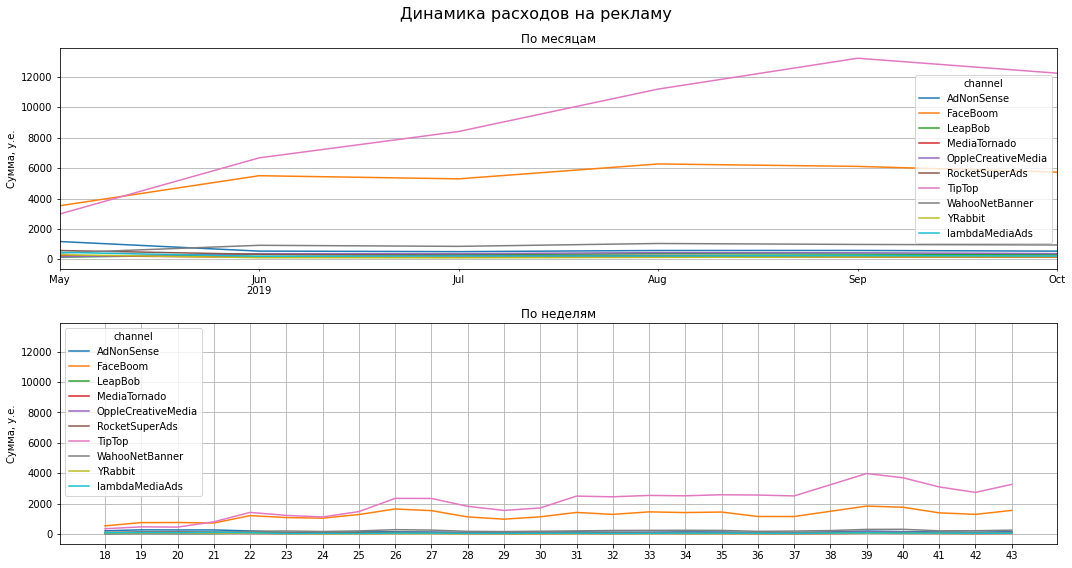

In [19]:
# добавим недостающие столбцы (week, month)
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].astype('datetime64[M]')

# строим графики динамики затрат по выбранным интервалам с общей осью
ax1 = plt.subplot(2, 1, 2)
ax1.subtitle = 'Динамика затрат на рекламу'
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum') \
          .plot(
                grid=True, 
                ax=ax1,
                figsize=(15, 8), 
                xticks=range(costs['week'].min(), costs['week'].max() + 1)
               )

plt.ylabel('Сумма, у.е.')
plt.xlabel('')
plt.title('По неделям')

ax2 = plt.subplot(2, 1, 1, sharey = ax1)
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum') \
          .plot(
                grid=True, 
                ax=ax2
               )
plt.ylabel('Сумма, у.е.')
plt.xlabel('')
plt.title('По месяцам')

plt.suptitle("Динамика расходов на рекламу", fontsize=16)
plt.tight_layout()

plt.show()

**Вывод: Среди каналов рекламы можно выделить `TipTop` и `FaceBoom` затраты на которые постоянно росли. По остальным источникам затраты примерно одинаковы в течение всего рассматриваемого периода в независимости от интервала (месяц/неделя). `FaceBoom` характеризуется незначительным ростом расходов до начала июня после расходы распределяются равномерно по всему оставшемуся периоду с незначительными всплесками на 22-ой, 26-ой, 39-ой и 40-ой неделях. В месячной динамике наблюдаются два пика в июне и августе. Наибольший рост затрат отмечен у канала `TipTop`. На месячном графике наблюдается постоянный рост с пиком затрат в сентябре, около 13,5 тыс. а после незначительный спад. Рост недельных значений не такой явный, и тем не менее после 31-ой недели затраты на этот канал более чем двукратно превышают значения `FaceBoom`.**

In [20]:
# для дальнейших расчетов показателей окупаемости отфильтруем данные из источника "organic" для профилей пользователей
profiles = profiles.query('channel != "organic"')

In [21]:
# средние затраты по каналам
profiles.groupby('channel')['acquisition_cost'].mean().round(2).sort_values(ascending=False)

channel
TipTop                2.80
FaceBoom              1.11
AdNonSense            1.01
lambdaMediaAds        0.72
WahooNetBanner        0.60
RocketSuperAds        0.41
OppleCreativeMedia    0.25
MediaTornado          0.22
YRabbit               0.22
LeapBob               0.21
Name: acquisition_cost, dtype: float64

In [22]:
print(f'Средний CAC: {profiles.acquisition_cost.mean().round(2)} у.е.')

Средний CAC: 1.13 у.е.


**Вывод: Всего три канала имеют средние затраты на пользователя более 1 у.е.: TipTop, FaceBoom и AdNonSense. Наибольшие вложения сделаны в канал `TipTop`, около 2.8 у.е. что двукратно превышает затраты на источник, который идет на втором месте по средним затратам на пользователя `FaceBoom`.**

In [23]:
# доля первых двух каналов в общих расходах на рекламу

expensive_channels = (profiles.groupby('channel')['acquisition_cost']
                              .mean().round(2)
                              .sort_values(ascending=False)[:2]
                              .index.to_list()
)

print('Общая доля самых дорогих каналов: {:.2f}%'.format(
        (costs.query("channel in @expensive_channels").costs.sum() / costs.costs.sum()) * 100
   )
)

Общая доля самых дорогих каналов: 82.65%


<i><b>Вывод по разделу:</b></i> 
Общая сумма расходов на рекламу составила около 105.5 тыс. у.е., общая доля <b>TipTop</b> и <b>FaceBoom</b> составила 82.65% от общего рекламного бюджета. Положительной динамикой расходов отметились только эти два источника, по остальным каналам затраты не менялись. Общие затраты составили 1.13 у.е. в расчете на одного пользователя.

### Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Будем считать , что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

In [24]:
# зададим момент анализа и горизонт планирования
observation_date = datetime(2019, 11, 1).date()  # момент анализа 1-ое октября 2019 года.
horizon_days = 14  # горизонт анализа две недели.

In [25]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = (
    get_ltv(
            profiles, orders, observation_date, horizon_days, ignore_horizon=False
    )
)

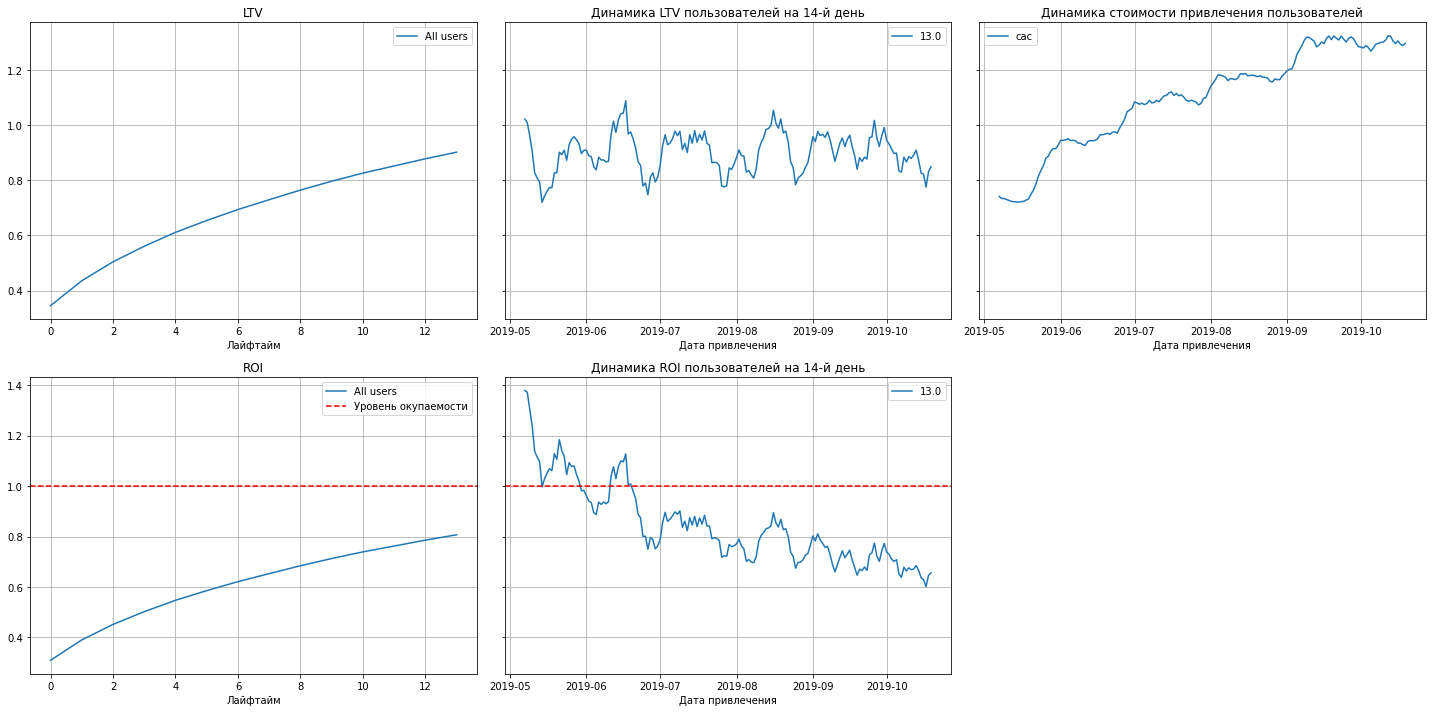

In [26]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

<p><b>По графикам можно сделать следующие выводы:</b>
<li>К концу 2-ой недели ROI достигает 80%. Общая динамика показателя имеет тренд к снижению.
<li>CAC характеризуются постоянным ростом.Ближе к середине сентября рост замедляется и наступает стагнация.
<li>На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен.

In [27]:
conversion_raw, conversion_grouped, conversion_history = (
    get_conversion(
            profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False
    )
)

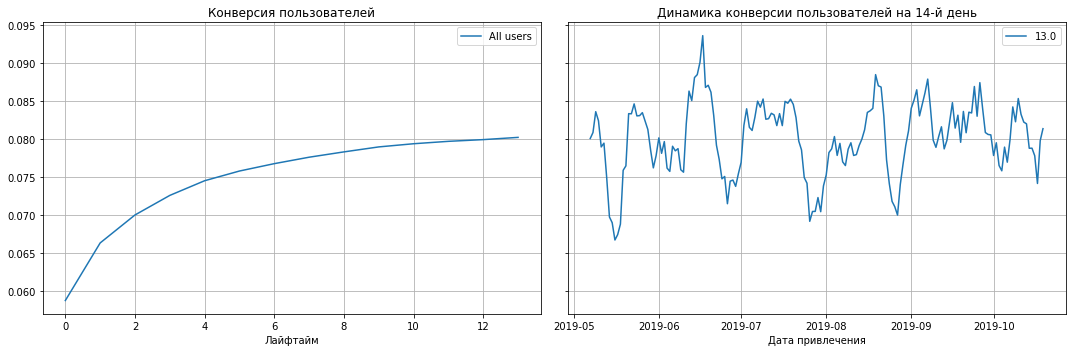

In [28]:
plot_conversion(conversion_grouped, conversion_history, horizon_days)

In [29]:
retention_raw, retention_grouped, retention_history = (
    get_retention(
        profiles, visits, observation_date, horizon_days, dimensions = [], ignore_horizon = False
    )
)

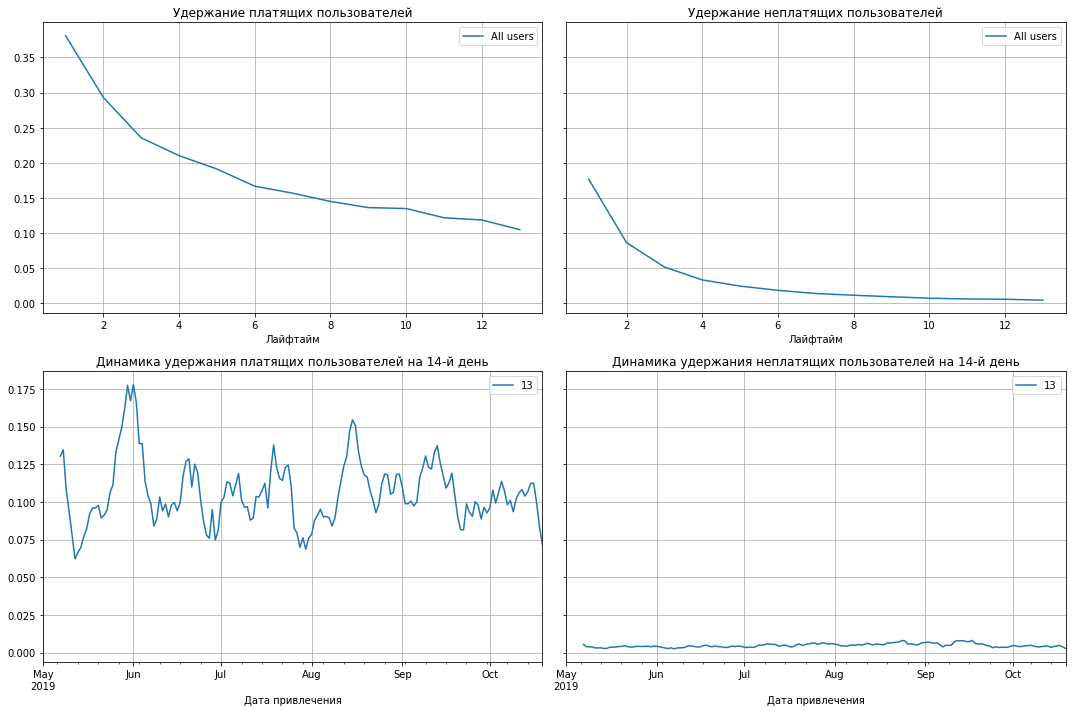

In [30]:
plot_retention(retention_grouped, retention_history, horizon_days)

**Графики конверсии и удержания не дают нам особых зацепок, поэтому проведем мини-иследование по всем доступным параметрам.**

#### Устройства

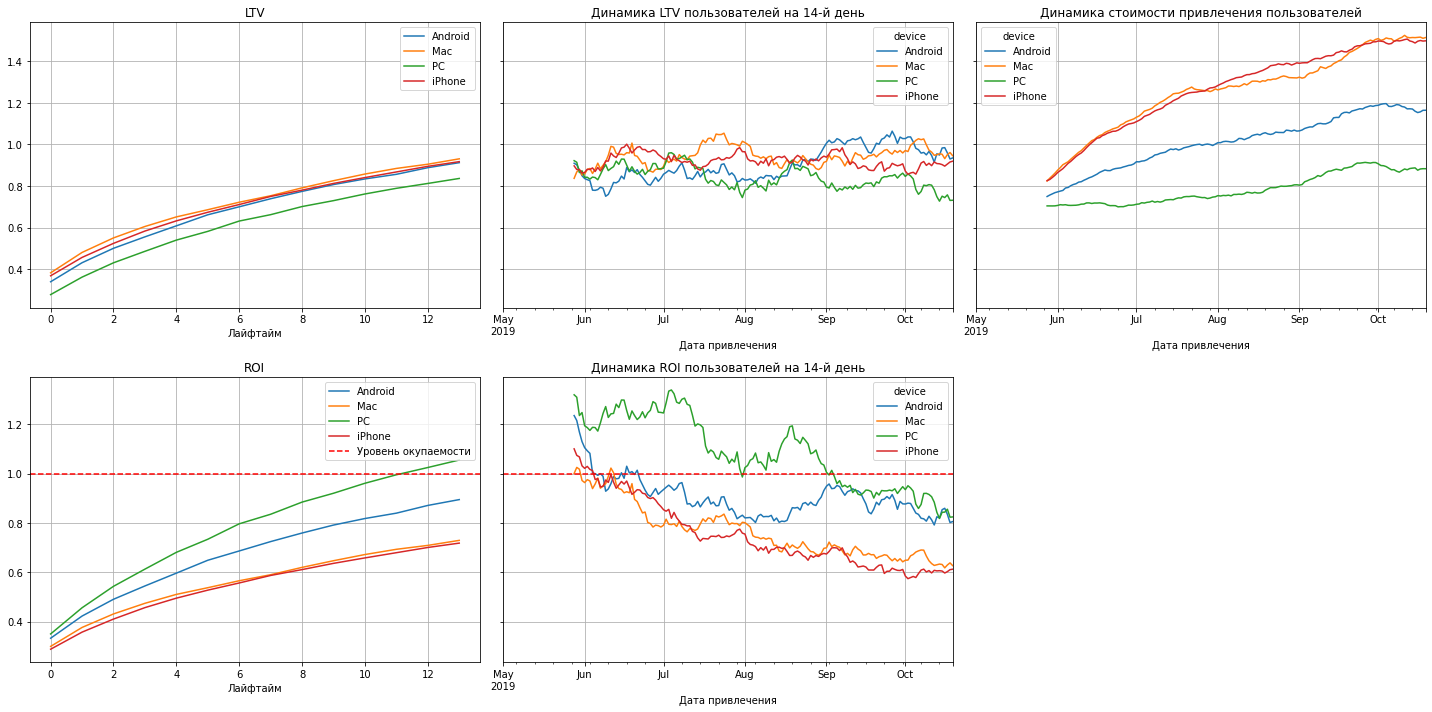

In [31]:
# смотрим окупаемость с разбивкой по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = (
    get_ltv(profiles, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False
    )
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=28)

**Разбивка по устройствам показала низкую окупаемость среди пользователей всех устройств, особенно среди Mac и iPhone при общей динамике стоимости привлечения выше чем на других устройствах к концу 2-ой недели на уровне 70%.**

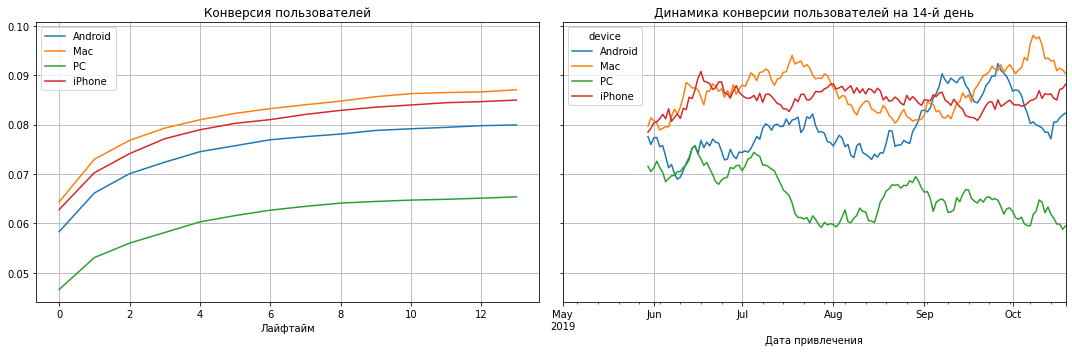

In [32]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = (
    get_conversion(
        profiles, orders, observation_date, horizon_days, dimensions=dimensions
    )
)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=30)

Хуже всего конвертируются пользователи <b>PC</b> около 6.5% к концу 2-ой недели. По остальным устройствам этот показатель чуть выше: <b>Android</b> - 8%, <b>iPhone</b> и <b>Mac</b> выше 8.5%.

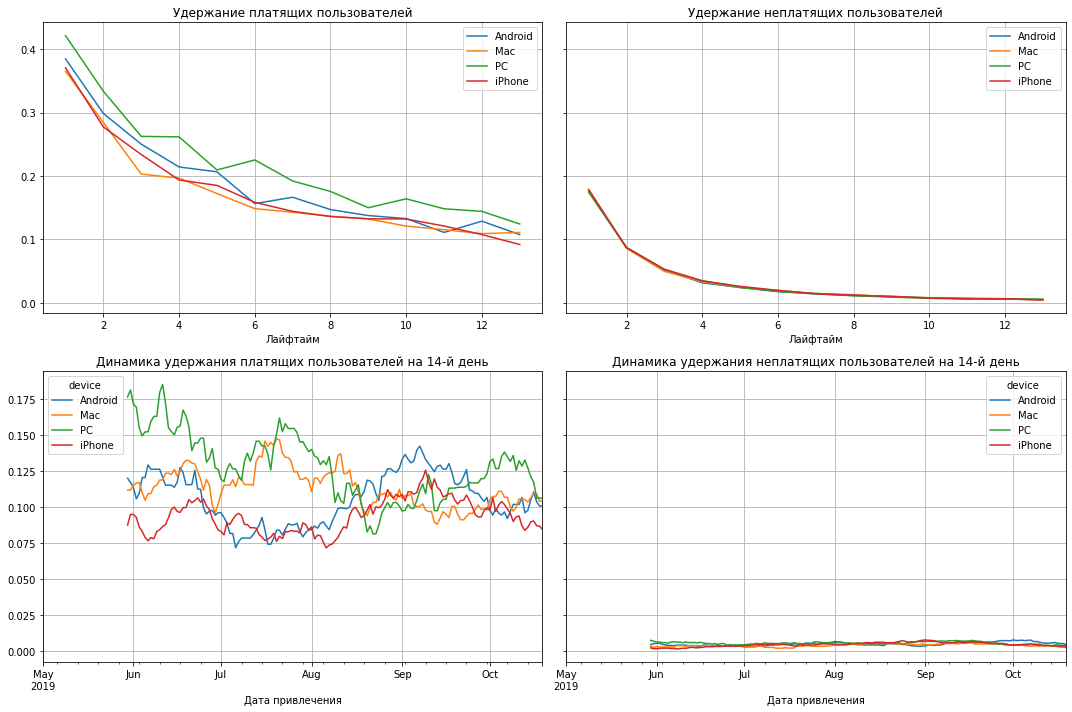

In [33]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = (
    get_retention(
        profiles, visits, observation_date, horizon_days, dimensions=dimensions
    )
)

plot_retention(retention_grouped, retention_history, horizon_days, window=30)

#### Страны

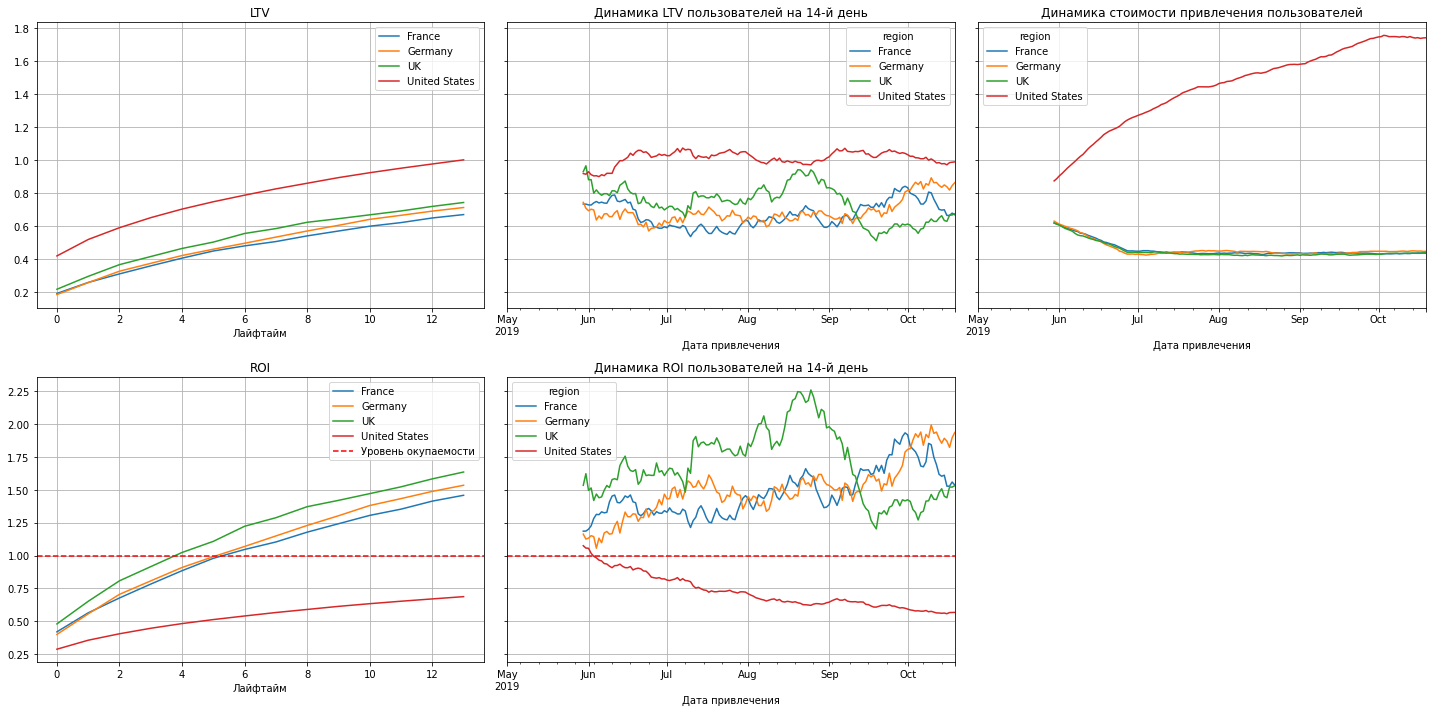

In [34]:
# смотрим окупаемость с разбивкой по странам
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = (
    get_ltv(profiles, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False
    )
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30)

Окупаемость пользователей <b>United States</b> демонстрирует самый низкий уровень (к концу 2-ой недели на уровне 75%) и отрицательную динамику при постоянном росте расходов на рекламу. ROI в <b>UK</b> достигает уровня окупаемости на 4-ый день, а в остальных регионах на день позже.  

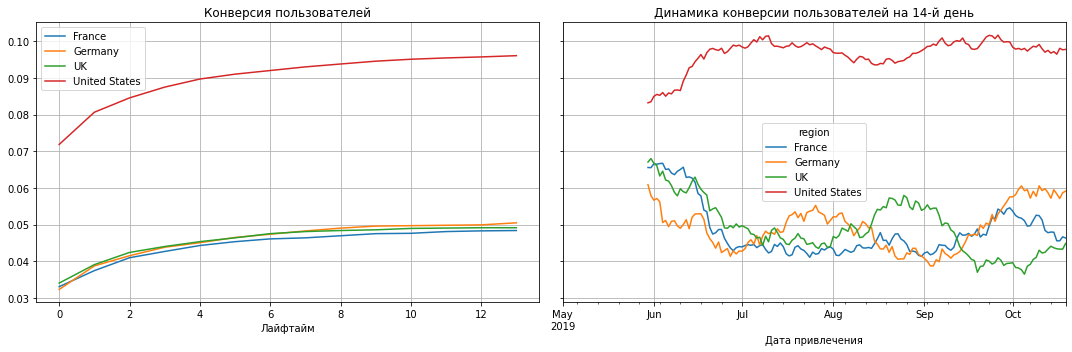

In [35]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = (
    get_conversion(
        profiles, orders, observation_date, horizon_days, dimensions=dimensions
    )
)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=30)

Пользователи из <b>United States</b> конвертируются лучше остальных стран, на уровне 9.5%. В остальных странах этот показатель гораздо ниже в районе 5%.   

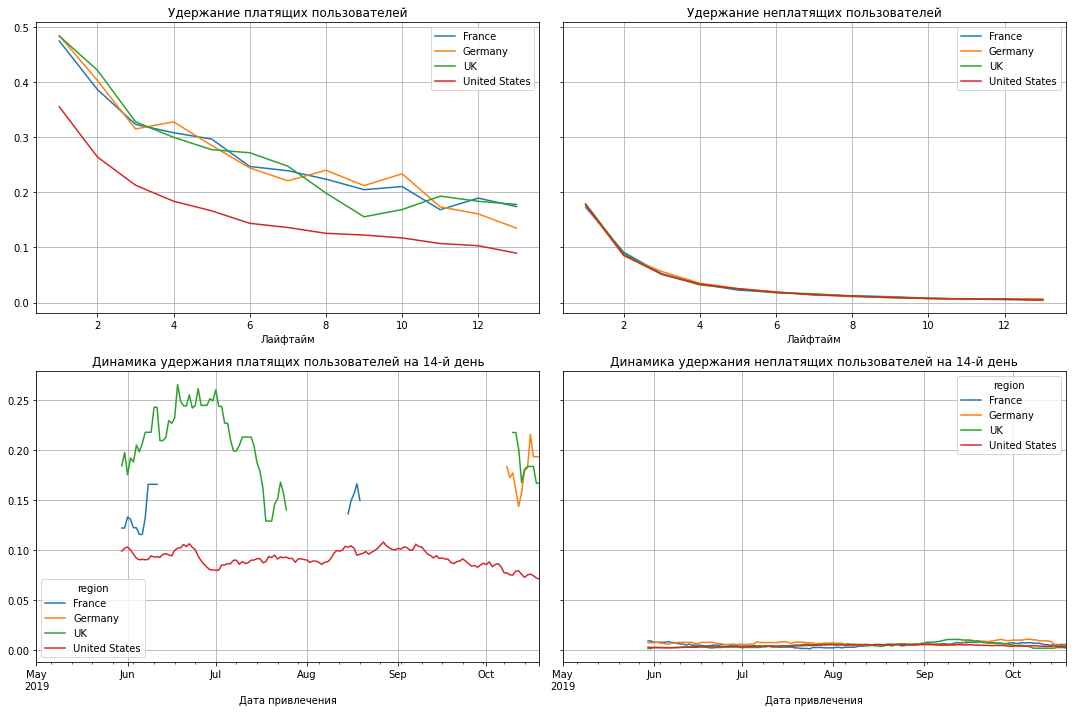

In [36]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = (
    get_retention(
        profiles, visits, observation_date, horizon_days, dimensions=dimensions
    )
)

plot_retention(retention_grouped, retention_history, horizon_days, window=30)

Графики говорят о низком удержании пользователей из <b>United States</b>, а также об отрицательной динамике удержания 14-го дня. 

Пользователи из <b>United States</b> имеют высокий процент конвертации, но очень плохо удерживаются. Окупаемость вложений при растущей динамике расходов тоже не внушает оптимизма, около 75% к концу 14-го лайфтайма.

#### Каналы

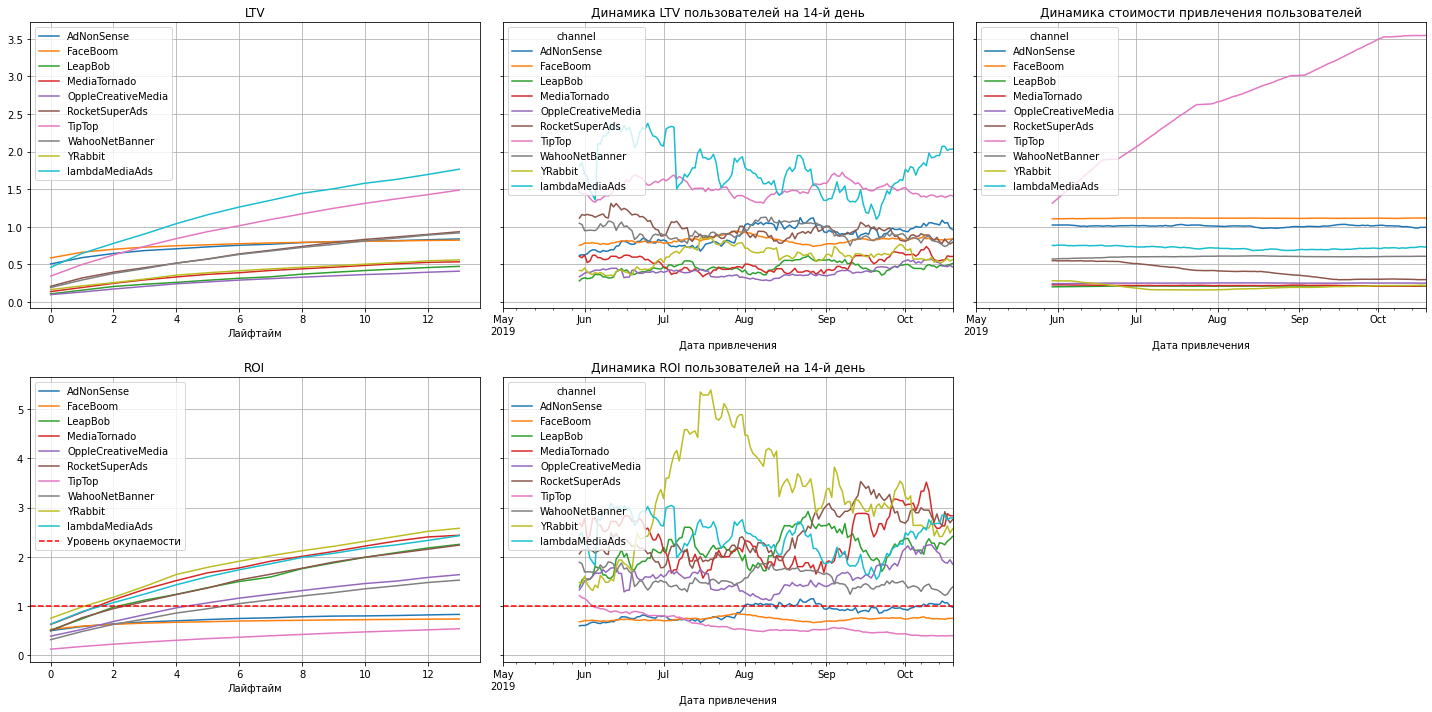

In [37]:
# смотрим окупаемость с разбивкой по каналам
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = (
    get_ltv(profiles, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False
    )
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30)

Ниже уровня окупаемости находятся такие источники как: <b>TipTop</b>, <b>FaceBoom</b> и <b>AdNonSense</b> - каналы имеющие самые большие затраты на привлечение. 

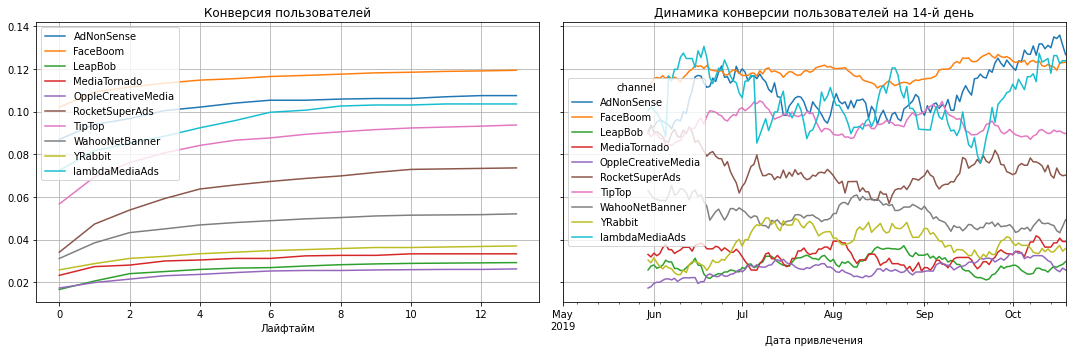

In [38]:
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = (
    get_conversion(
        profiles, orders, observation_date, horizon_days, dimensions=dimensions
    )
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=30)

Высокая конверсия наблюдается среди источников: 
    <li><b>FaceBoom</b> - 12%; 
    <li><b>AdNonSense</b> и <b>lambdaMediaAds</b>  - выше 10%;
    <li><b>TipTop</b> - выше 9%.
        
Все остальные каналы имеют конверсию ниже 8%.        

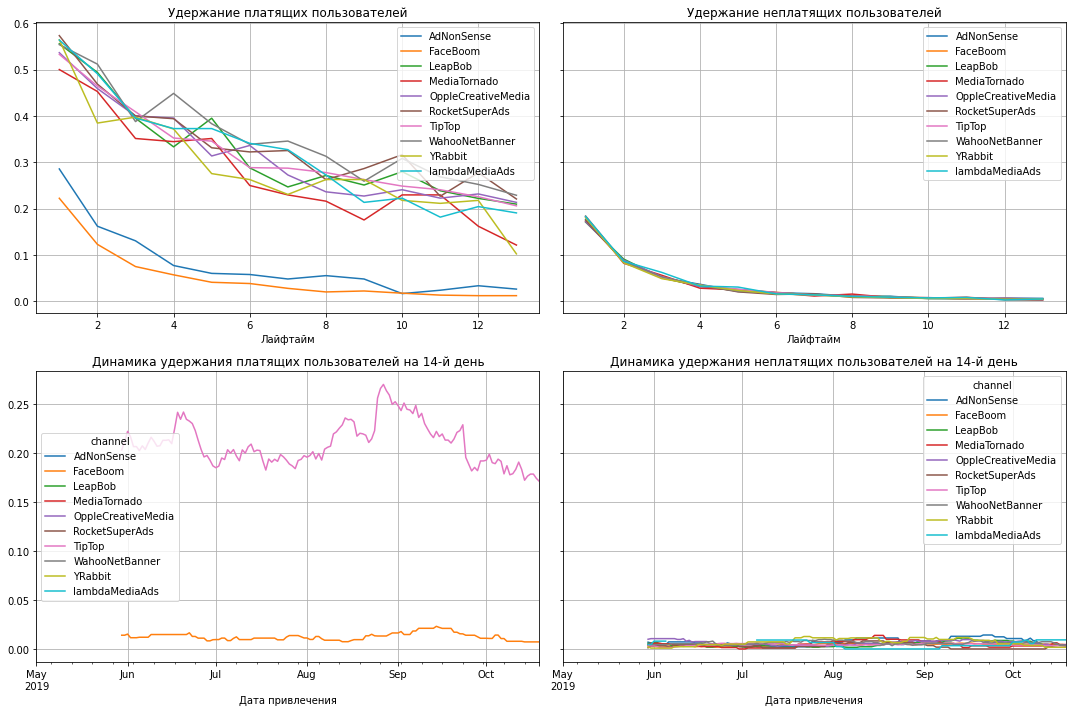

In [39]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = (
    get_retention(
        profiles, visits, observation_date, horizon_days, dimensions=dimensions
    )
)

plot_retention(retention_grouped, retention_history, horizon_days, window=30)

Самое низкое удержание наблюдается среди пользователей привлеченных по каналам: <b>FaceBoom</b> и <b>AdNonSense</b>. Вероятнее всего, платящие пользователи пришедшие из других каналов не успевают "прожить" весь 14-дневный лайфтайм, поэтому на графике удержания 14-го дня отсутствуют все остальные источники за исключением <b>TipTop</b> и <b>Faceboom</b>.  

<i><b>Вывод по разделу:</b></i>
    <ul>
        <li>Можно сказать, что реклама в целом не окупается и к концу 2-ой недели ROI достигает всего лишь 80%.
        <li><b>Mac</b> и <b>iPhone</b> при общей динамике стоимости привлечения выше чем на других устройствах к концу 2-ой недели так и не достигает уровня окупаемости. 
        <li>Окупаемость пользователей <b>United States</b> демонстрирует самый низкий уровень при постоянном росте расходов на рекламу.
        <li>Ниже уровня окупаемости находятся такие источники как: <b>TipTop</b>, <b>FaceBoom</b> и <b>AdNonSense</b> - каналы имеющие самые большие затраты на привлечение, но они же демонстрируют самую высокую конверсию среди остальных источников привлечения.    
    </ul> 

Для формулировки общих выводов проведем небольшое исследование делая акцент на страну (<b>United States</b>), тип устройства (<b>Mac</b> и <b>iPhone</b>) и каналы привлечения с самыми высокими расходами (<b>TipTop</b> и <b>FaceBoom</b>). 

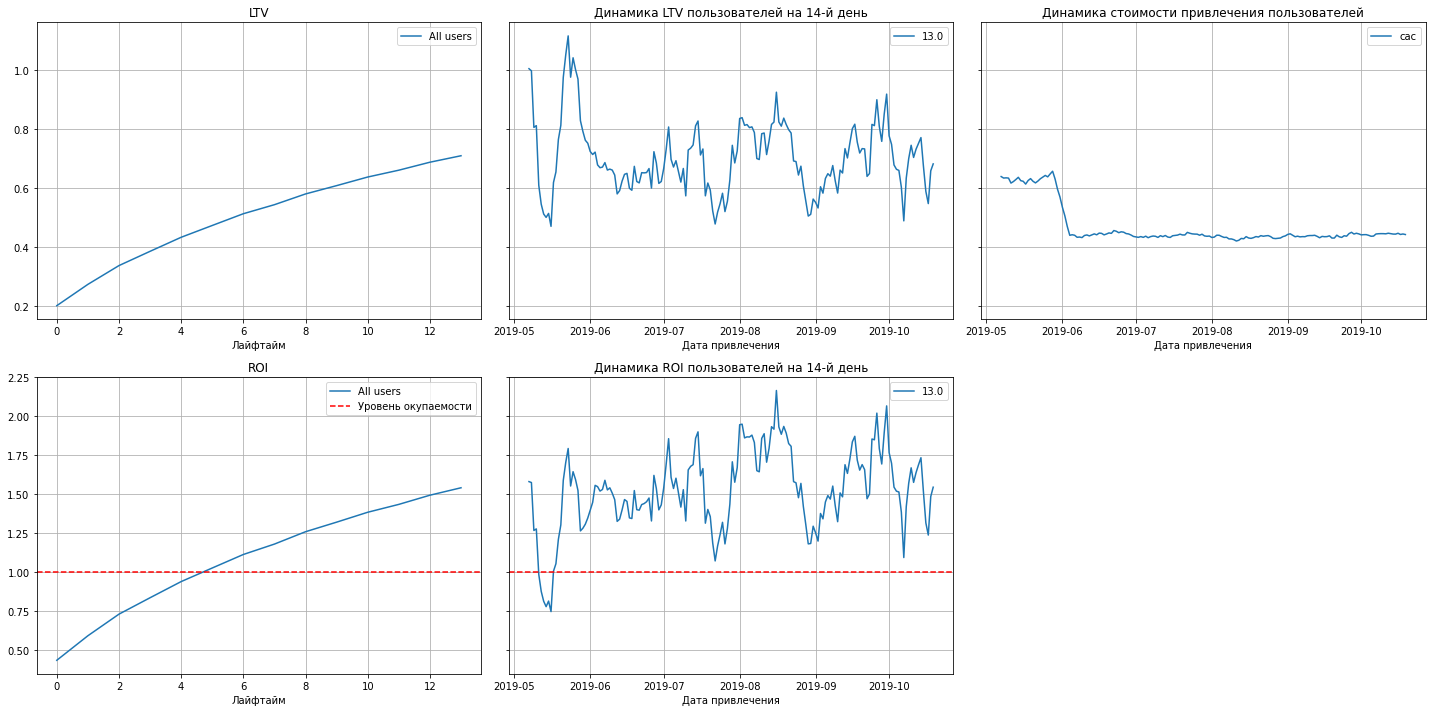

In [40]:
# визуализируем затраты и окупаемость исключив США
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = (
    get_ltv(
            profiles.query('region != "United States"'), orders, observation_date, horizon_days, ignore_horizon=False
    )
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Исходя из графиков, можно утверждать о том, что на общую негативную картину неэффективности рекламы оказывают влияние пользователи из США. Исключив регион <b>United States</b> мы получили положительные результаты по общей окупаемости, к концу 2-ой недели выше 150%.

In [41]:
profiles.query('payer == True').value_counts('region', normalize=True).mul(100).round(2)

region
United States    79.11
UK                7.37
France            7.18
Germany           6.35
dtype: float64

Но они же составляют "львиную" долю среди платящих пользователей среди остальных стран, 79%.   

In [42]:
# распределение платящих пользователей по устройствам в каждой стране, в процентах

devices_by_region = (
                     profiles.query('payer == True')
                             .pivot_table(index='device', columns='region', values='user_id', aggfunc='count')
                             .merge(
                                    profiles.query('payer == True')
                                            .pivot_table(index='device', columns='region', values='user_id', aggfunc='count')        
                                            .cumsum(axis=1)['United States']
                                            .to_frame()
                                            .rename(columns={'United States': 'total'}),
                                    on='device'
                                  )    
                    )

devices_by_region = devices_by_region.div(devices_by_region['total'], axis=0).mul(100).round(2)

devices_by_region.iloc[:, 0:4]

,France,Germany,UK,United States
device,,,,
Android,8.31,8.08,9.71,73.91
Mac,4.12,2.87,2.93,90.08
PC,17.08,15.46,18.78,48.69
iPhone,3.90,3.30,3.50,89.30


Еще одно подтверждение причин ухудшения окупаемости по утройствам - 90% платящих пользователей <b>Mac</b> и <b>iPhone</b> находятся в США. Возникает предположение о том, что плохое удержание пользователей связано с техническими проблемами на данных типах устройств. Для проверки проведем анализ продолжительности каждой сессии, найдем средние показатели и сравним с данными из США.  

In [43]:
# создадим копию visits и добавим поле с продолжительностью каждой сессии в минутах

visits_copy = visits.copy()
visits_copy['duration'] = visits_copy['session_end'] - visits_copy['session_start']
visits_copy['duration'] = visits_copy['duration'].apply(lambda x: x/np.timedelta64(1,'m')).round(2)

In [44]:
# платящие пользователи
payers = profiles.query('payer == True')['user_id'].to_list()

In [45]:
# отфильтруем данные по платящим и составим сводную таблицу 
# со средними показателями длительности по каналам привлечения
visits_copy.query('user_id in @payers') \
           .pivot_table(index='channel', 
                        columns='region', 
                        values='duration', 
                        aggfunc='mean', 
                        fill_value='-')

region,France,Germany,UK,United States
channel,,,,
AdNonSense,30.234729,30.729899,29.542906,-
FaceBoom,-,-,-,30.069917
LeapBob,28.27745,29.091657,30.058629,-
MediaTornado,-,-,-,29.390593
OppleCreativeMedia,28.538234,31.253387,29.115547,-
RocketSuperAds,-,-,-,30.059985
TipTop,-,-,-,30.262829
WahooNetBanner,29.131167,29.259198,29.270362,-
YRabbit,-,-,-,29.855845


In [46]:
# по странам и устройствам
visits_copy.query('user_id in @payers') \
           .pivot_table(index='region', 
                        columns='device', 
                        values='duration', 
                        aggfunc='mean', 
                        fill_value='-')

device,Android,Mac,PC,iPhone
region,,,,
France,29.182370,29.696092,28.866688,28.908704
Germany,30.171850,29.767021,29.415822,29.585045
UK,30.686107,28.609089,29.149671,29.604256
United States,30.283042,30.025009,30.247188,30.123573


Средняя продолжительность сессии не дает никаких зацепок - средняя сессия во всех странах и по всем каналам около получаса вне зависимости от устройства входа. <b>Предположение о снижении удержания из-за технических проблем не оправдалось.</b>

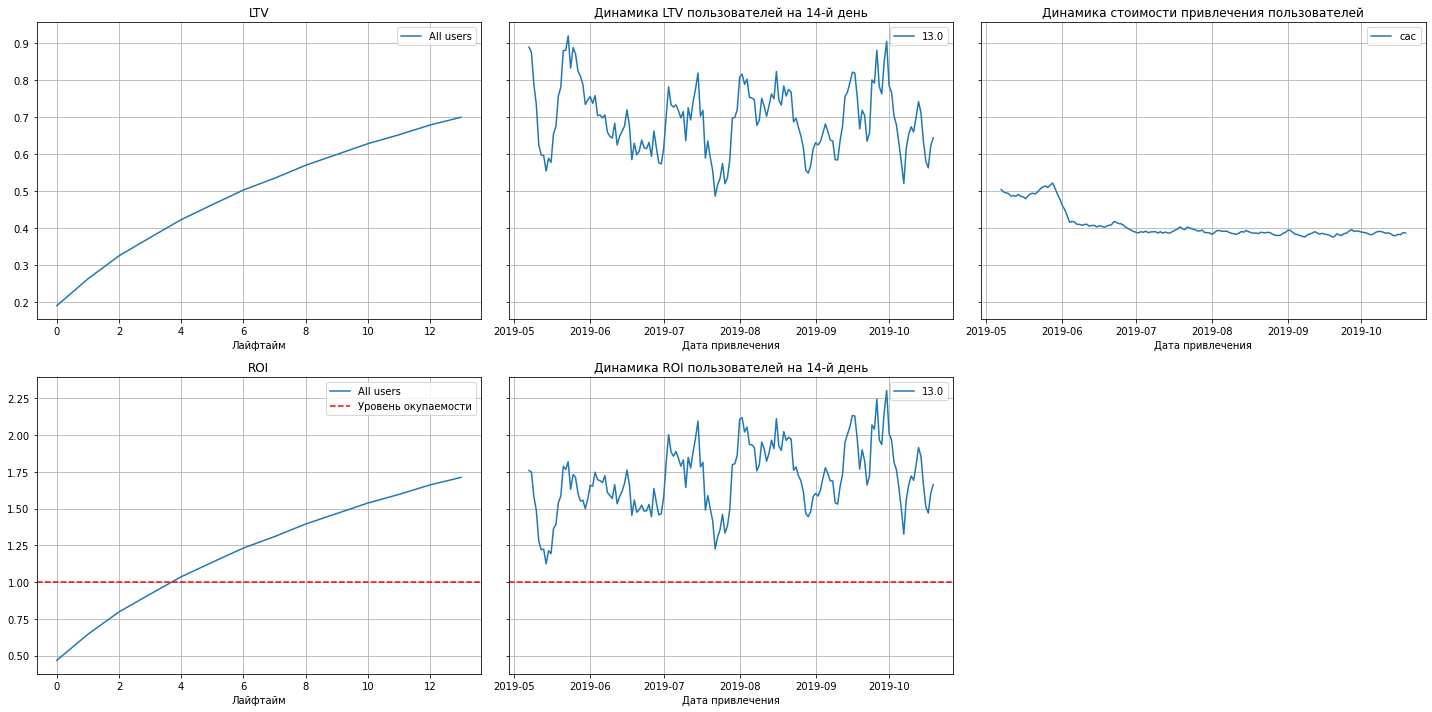

In [47]:
# визуализируем затраты и окупаемость исключив самые дорогие каналы
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = (
    get_ltv(
            profiles.query('channel not in ("TipTop", "FaceBoom")'), orders, observation_date, horizon_days, ignore_horizon=False
    )
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Исключив из выборки самые дорогостоящие каналы получаем выход на уровень окупаемости к 4-ому дню при сохранении низкого уровня затрат (САС).Вероятно проблема с приходящим по этим каналам трафиком.


<b><i>ОБЩИИ ВЫВОД:</i></b>
<p>Низкий уровень общей окупаемости (ROI на уровне 80-ти процентов) напрямую зависит от больших затрат на два канала <b>TipTop</b> и <b>FaceBoom</b> (совокупные затраты на уровне 83 процентов от всего бюджета). Этот фактор также вляеяет на показатели удержания и окупаемость в регионе <b>United States</b> и двух типов устройств (<b>Mac</b> и <b>iPhone</b>), имеющие наибольшее распространение именно в США.

<b><em>Рекомендации:</em></b> <i>Оптимизировать расходы каналов FaceBoom и TipTop по причине больших затрат, почти 83% от общих расходов на рекламу. Возможно таргетирование рекламы этих источников направлено на низкоплатежный сегмент (как вариант молодежь/студенты) по этой причине низкий уровень удержания. Для подтверждения/опровержения данного предположения требуется провести дополнительный анализ особенностей приходящего трафика (пол, возраст и т.п.).</i> 